In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#final=final.drop_duplicates(subset={"UserId","ProductId","Time"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

 Text Preprocessing


In [11]:
# find sentences containing HTML tags
import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)



{'ourselves', 'which', "doesn't", 'further', 'theirs', 'from', 'myself', 'yourself', 'or', 't', 'few', "shouldn't", 'until', 'doesn', "needn't", 'their', 'to', 'a', 'all', "she's", 'both', 'before', 'here', 'can', 'when', 're', 'haven', 'whom', 'is', 'her', 'out', 'be', 'me', 'ours', 'i', 'hers', 'if', "you've", 'own', "couldn't", 'themselves', 'shouldn', 'had', 'then', 'your', 'after', 'through', 'him', "that'll", 'am', 'were', 'under', "weren't", "mustn't", 'because', 'ain', "won't", 'up', 'do', "aren't", 'shan', 'the', 'was', 'now', 'd', 'doing', 's', 'did', 'into', 'he', 'having', 'down', 'them', 'but', 'its', 'over', 'his', 'an', "hasn't", 've', 'hadn', 'between', 'same', 'you', 'does', 'on', "you'll", 'no', 'each', 'yourselves', 'it', 'while', 'hasn', 'been', 'only', 'there', "you'd", 'are', 'some', 'where', 'mightn', "mightn't", 'more', 'of', 'how', 'should', 'mustn', 'than', "you're", 'we', 'has', 'nor', 'other', 'this', 'our', 'herself', 'wouldn', "shan't", 'and', 'y', "wouldn

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

 Bag of Words (BoW)

In [15]:
final_samp = pd.DataFrame(final)# Converting the table to a dataframe

In [16]:
# Sampling 30K rows from whole table
final_sample = final_samp.sample(n=30000)
final_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
456127,493156,B003TC7WN4,A1D1UB7995POKS,Mrs. M. M. Albers,0,0,negative,1294790400,Wolf Gang's Kcup Breakfast Blend a Sleeper,"I ordered Wolf Gang Puck's k cups, largely bec...",b'order wolf gang puck cup larg reput experi r...
353166,382001,B000A0WMX8,A2H74FIBDN5NMR,"M. Prieto ""Havanese friend""",0,0,positive,1286150400,Refreshing and delicious! Great for the tummy.,I love this tea! I've had other mint teas but ...,b'love tea ive mint tea far strongest tast del...
246427,267206,B002OFU7MK,A2QKQWI57N451S,Judi Semel,0,1,negative,1245196800,sweet mcnuggets,these are good but verrry sweet.... they taste...,b'good verrri sweet tast kind chines sweet bbq...
205301,222433,B004E4CCSQ,AVHN134ADVP4R,"A4Q96 ""Gadget Lover""",0,1,positive,1326931200,"Like it, but expensive","the MIO Liquid peach tea is tasty, convenient,...",b'mio liquid peach tea tasti conveni easi enou...
233385,253165,B001EQ4IES,A51O8S0HDXOK3,Gregory Maddox Sr.,0,0,positive,1322179200,Great Coffee!!!,This is a Great blend of coffee full of flavor...,b'great blend coffe full flavor robust excel v...
266379,288754,B000H221VC,A2N0OB19XMC1E2,"NapaGirl ""NapaGirl""",0,0,positive,1222992000,Hatch sauces,"These sauces are amazing- the absolute best, t...",b'sauc absolut best make huge differ recip btw...
277382,300599,B0011MUFV0,A10005QPZS2TCW,Deb,3,3,positive,1293753600,Satisfaction,This was a gift and the people get really surp...,b'gift peopl get realli surpris charm basket d...
403157,435935,B004CT9F9M,A35LTOF1VKIHO1,Malia,0,0,positive,1349913600,all gone within days.,Got them just a day or two after buying them.<...,b'got day two buy gone day everyon love buy di...
159615,173037,B001CCQVGW,A1VCNE6MMXYY3P,"Gerryq ""Gerry""",10,11,positive,1270080000,Luscious Lemon Cake Mix,This is my favorite of the Dassant mixes (and ...,b'favorit dassant mix pretti terrif made instr...
323819,350490,B0002XIBLA,A3FGFXV9MB1246,"Saki ""Saki""",3,3,positive,1204588800,"The best, but hard to find",I love this stuff! Really chocolatey and malt...,b'love stuff realli chocolatey malti much bett...


In [17]:
# Converting the BOW text to vector in d-dimensions using CountVectorizer.

count_vect = CountVectorizer() 
final_counts = count_vect.fit_transform(final_sample['CleanedText'].values)


In [18]:
type(final_counts) # type of matrix i.e. sparse matrix

scipy.sparse.csr.csr_matrix

In [19]:
final_counts.get_shape() # shape of CountVectorizer matrix

(30000, 21685)

In [20]:
print(final_counts) # printing the final_counts

  (0, 17324)	1
  (0, 17656)	1
  (0, 10355)	1
  (0, 15097)	1
  (0, 5335)	1
  (0, 20849)	1
  (0, 9075)	1
  (0, 5697)	1
  (0, 3765)	1
  (0, 18819)	1
  (0, 1932)	1
  (0, 2265)	1
  (0, 6956)	1
  (0, 5661)	1
  (0, 9113)	1
  (0, 8027)	2
  (0, 15832)	1
  (0, 6527)	1
  (0, 15781)	1
  (0, 10550)	1
  (0, 4591)	3
  (0, 15029)	1
  (0, 7621)	2
  (0, 21252)	2
  (0, 13338)	1
  :	:
  (29998, 14364)	1
  (29998, 14892)	1
  (29998, 4790)	1
  (29998, 7778)	1
  (29999, 11856)	1
  (29999, 4412)	1
  (29999, 5527)	1
  (29999, 2750)	1
  (29999, 3264)	1
  (29999, 17837)	1
  (29999, 5227)	1
  (29999, 8681)	1
  (29999, 19138)	1
  (29999, 5872)	2
  (29999, 7854)	1
  (29999, 12277)	1
  (29999, 20805)	1
  (29999, 21263)	1
  (29999, 1338)	1
  (29999, 7181)	1
  (29999, 5215)	1
  (29999, 13997)	1
  (29999, 21334)	1
  (29999, 11074)	1
  (29999, 13338)	1


In [21]:
Review = final_sample['Score'] # Storing the Score Column in a dataframe Review.

In [22]:
print(Review) # printing the Review

456127    negative
353166    positive
246427    negative
205301    positive
233385    positive
266379    positive
277382    positive
403157    positive
159615    positive
323819    positive
296332    positive
254844    positive
330865    positive
522086    positive
9487      positive
289552    negative
474492    positive
340202    positive
180239    positive
424559    positive
145770    positive
133378    positive
194128    positive
40666     positive
30374     positive
408725    positive
42002     negative
32844     positive
253510    positive
483421    positive
            ...   
206774    positive
320588    positive
63027     positive
174593    positive
86195     positive
195716    negative
33811     positive
465746    positive
298985    positive
413952    positive
458430    positive
121172    positive
78010     positive
181679    negative
454271    positive
468903    positive
441910    positive
195671    positive
440430    positive
34970     positive
466512    positive
126995    po

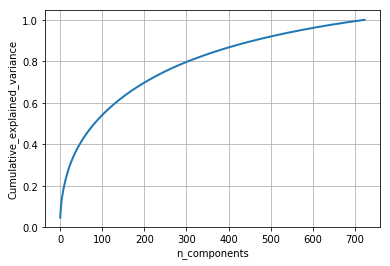

In [25]:
'''
Plotting a CDF on number of components and cumulative_variance_explained to choose the best value of number of components 
such that maximum varince is explained.

'''

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


svd = TruncatedSVD(n_components = 724)
pca_data = svd.fit_transform(final_counts)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 600-dimensions, approx. 97% of variance is explained.

In [26]:
# Taking only 600 dimensions as almost 97% variance is explained by the cdf.

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Using TruncatedSVD for dimensionality reduction as the matrix is a sparse matrix and TruncatedSVD works on sparse matrix
svd = TruncatedSVD(n_components = 600)
pca_data = svd.fit_transform(final_counts)

print("Truncated Svd Reduced Shape = ", pca_data.shape)

Truncated Svd Reduced Shape =  (30000, 600)


In [32]:
# Standardizing the data with mean=0 and variance=1

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(pca_data)
print(standardized_data.shape)


(30000, 600)


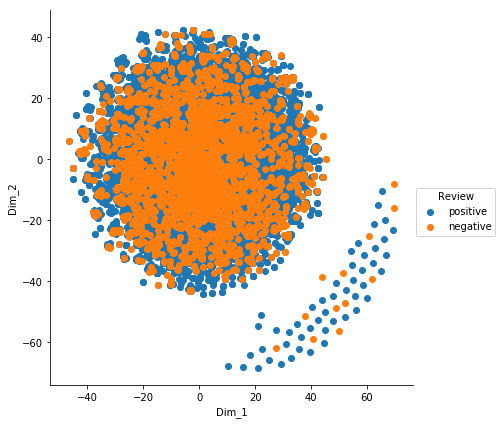

In [34]:
'''
standardizing the data and plotting with t-sne with perplexity = 50 and n_components=2 and n_iter = 1500 and 
plotting using seaborn and we can see the positive and negative points are not easily seperable, but the problem is they
are almost overlapping.

'''

from sklearn.manifold import TSNE

data_1000 = standardized_data[0:20000,:]
Score_1000 = Review[0:20000]

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1500)

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Score_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


 TF-IDF

In [23]:
# Using along bi-gram for calculating tfidf Vectorizer as taking tri-grams or more will increase the dimensionality.


tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_sample['CleanedText'].values)


In [24]:
final_tf_idf.get_shape() # Shape/Size of the tf-idf sparse matrix.


(30000, 538562)

In [25]:
# Length of features in the tfidf-Vectorizer.
features = tf_idf_vect.get_feature_names()
len(features)


538562

In [26]:
f1 = tf_idf_vect.get_params(deep=True) # Parameters mapped to their values.
f1

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

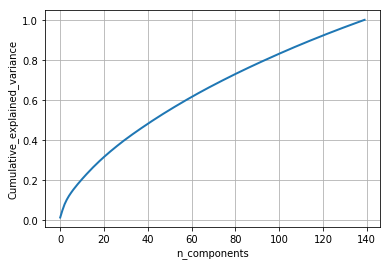

In [27]:
'''
Plotting a CDF on number of components and cumulative_variance_explained to choose the best value of number of components 
such that maximum varince is explained.

'''


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

svd_tf = TruncatedSVD(n_components = 140)
svd_data_tf = svd_tf.fit_transform(final_tf_idf)

percentage_var_explained_tf = svd_tf.explained_variance_ / np.sum(svd_tf.explained_variance_);

cum_var_explained_tf = np.cumsum(percentage_var_explained_tf)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained_tf, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 130-dimensions, approx. 97% of variance is explained.

In [28]:
# Reducing the number of components to 130 as we can acheive approximately 97% variance.

# Using TruncatedSVD for dimensionality reduction as the matrix is a sparse matrix and TruncatedSVD works on sparse matrix
svd_tf = TruncatedSVD(n_components = 130)
svd_data_tf = svd_tf.fit_transform(final_tf_idf)

print("Truncated Svd Reduced Shape = ", svd_data_tf.shape)

Truncated Svd Reduced Shape =  (30000, 130)


In [29]:
# Standardizing the data using mean=0 and variance=1

from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf = StandardScaler().fit_transform(svd_data_tf)
print(standardized_data_tf_idf.shape)

(30000, 130)


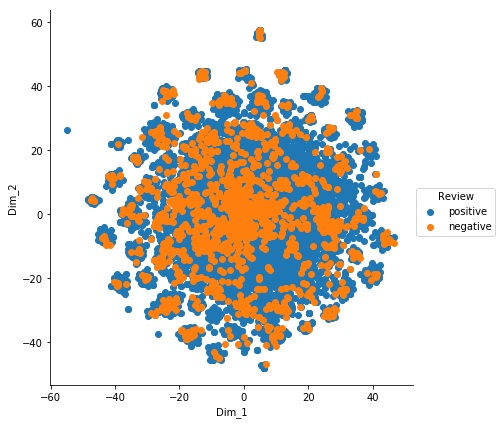

In [41]:
'''
standardizing the data and plotting with t-sne with perplexity = 70 and n_components=2 and n_iter = 1800 and 
plotting using seaborn and we can see the positive and negative points are not easily seperable, but they are still almost
overlapping but they are have made clusters or groups for both positive and negative reviews.

'''

from sklearn.manifold import TSNE

data_1000_tf = standardized_data_tf_idf[0:10000,:]
Score_1000_tf = Review[0:10000]

model_tf = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=1800)

tsne_data_tf = model_tf.fit_transform(data_1000_tf)


# creating a new data frame which help us in ploting the result data
tsne_data_tf = np.vstack((tsne_data_tf.T, Score_1000_tf)).T
tsne_df_tf = pd.DataFrame(data=tsne_data_tf, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tf, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


In [ ]:
Training Word2Vec using gensim and appending in the list


In [30]:
# Training Word2Vec using our corpus
import gensim
i=0
list_of_sent=[]
for sent in final_sample['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [31]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=3,size=100, workers=6)# workers=6 means using all the cores of CPU


Average Word2Vec 

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))# length of each feature in index[0]
print(len(sent_vectors[1]))# length of each feature in index[1]

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


30000
50
50


In [34]:
df = pd.DataFrame(sent_vectors) # converting the sparse matrix to dataframe
df.isnull().any() # checking if there is any is null in dataframe

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
dtype: bool

In [35]:
df = df.fillna(0) # filling the dataframe with 0 if there is any Nan entry

In [36]:
df.isnull().any() # checking if there is any null entry after 0 filled in NaN entries

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [50]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v = StandardScaler().fit_transform(df)
print(standardized_data_av_w2v.shape)

(30000, 50)


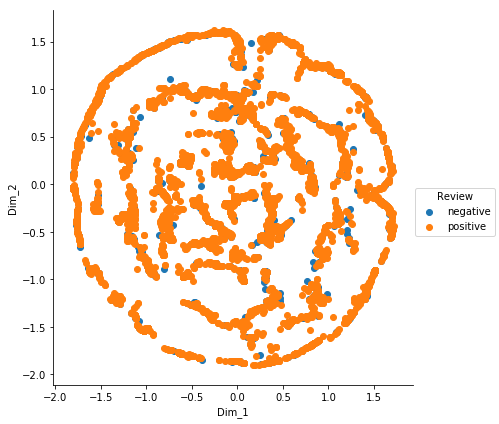

In [37]:
'''
standardizing the data and plotting with t-sne with perplexity = 30 and n_components=2 and n_iter = 1500 and 
plotting using seaborn and we can see the positive and negative points are seperable.

'''

from sklearn.manifold import TSNE

data_1000_w2v = standardized_data_av_w2v[0:10000,:]
Score_1000_w2v = Review[0:10000]

model_w2v = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1500)

tsne_data_w2v = model_w2v.fit_transform(data_1000_w2v)


# creating a new data frame which help us in ploting the result data
tsne_data_w2v = np.vstack((tsne_data_w2v.T, Score_1000_w2v)).T
tsne_df_w2v = pd.DataFrame(data=tsne_data_w2v, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_w2v, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
tfidf-w2v

In [38]:

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


30000
50


In [51]:
df1 = pd.DataFrame(tfidf_sent_vectors)

In [52]:
df1 = df1.fillna(0) # filling the dataframe with 0 if there is any Nan entry

In [53]:
df1.isnull().any() # checking if there is any null entry after 0 filled in NaN entries.

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [55]:
''' 
standardizing the data with mean = 0 and standard deviation = 1

'''

from sklearn.preprocessing import StandardScaler
standardized_data_tf_av = StandardScaler().fit_transform(df1)
print(standardized_data_tf_av.shape)

(30000, 50)


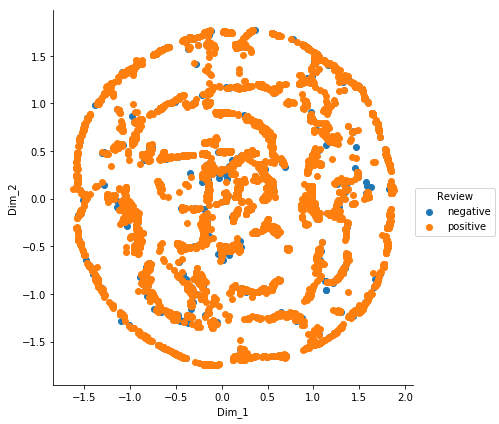

In [57]:
'''
standardizing the data and plotting with t-sne with perplexity = 40 and n_components=2 and n_iter = 1500 and 
plotting using seaborn and we can see the positive and negative points are seperable.

'''

from sklearn.manifold import TSNE

data_1000_tf_av = standardized_data_tf_av[0:10000,:]
Score_1000_tf_av = Review[0:10000]

model_tf_av = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=1500)

tsne_data_tf_av = model_tf_av.fit_transform(data_1000_tf_av)


# creating a new data frame which help us in ploting the result data
tsne_data_tf_av = np.vstack((tsne_data_tf_av.T, Score_1000_tf_av)).T
tsne_df_tf_av = pd.DataFrame(data=tsne_data_tf_av, columns=("Dim_1", "Dim_2", "Review"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tf_av, hue="Review", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()